### **Clustering implementation**

In this section, the previously selected clustering methods will be implemented.

#### **Justification for Variable Selection**

From the six original numerical variables, we selected `n_visitas`, `monto_descuentos`, and `monto_compras` for the clustering model. This decision was based on the following criteria:

**Reduction of Multicollinearity**

Correlation analysis revealed that some variables were highly related:

- `n_clicks` and `n_visitas` (correlation > 0.7).
- `n_clicks` and `monto_compras` (correlation ~ 0.6).

To avoid redundancy, we chose `n_visitas`, as it better represents customer interaction with the store. Additionally, the selected variables (`monto_descuentos` and `monto_compras`) are complementary and not highly correlated.

**Practical Relevance**

Variables such as `dias_primera_compra` and `info_perfil` showed low variability and limited ability to differentiate customers. In contrast, the three selected variables capture essential aspects:

- `n_visitas`: measures customer interaction.
- `monto_descuentos`: reflects sensitivity to promotions.
- `monto_compras`: represents the economic value contributed by the customer.

**Simplicity and Interpretability**

Using fewer variables improves the interpretability of results, reduces noise, and enhances cluster quality by focusing on key aspects of customer behavior.

**Empirical Testing**

Testing with all six original variables produced dispersed results and lower Silhouette and Davies-Bouldin scores. By reducing to these three variables, the models achieved clearer and more consistent cluster separation.

**Conclusion**

The selection of `n_visitas`, `monto_descuentos`, and `monto_compras` is supported by correlation analysis, practical relevance, and empirical results. These variables effectively represent customer behavior and provide a solid foundation for segmentation.

#### **Justification for Scaling Method**

Now, we will prepare the data for applying the selected clustering methods. Since different features may have different scales (e.g., `n_visitas` and `monto_compras`), it is crucial to scale the data to ensure all features are on a similar scale. This can be achieved using a scaler from scikit-learn.

##### **Scalers and Transformers: Description and Applicability**

| **Scaler**            | **Description**                                                                                   | **Applicability**                                                                                | **Not Applicable**                                                                            |
|------------------------|---------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **StandardScaler**     | Transforms variables to have a mean of 0 and a standard deviation of 1.                          | ✔ Useful for algorithms sensitive to magnitudes (e.g., K-means, PCA, SVM).                      | ❌ Data with non-normal distributions or extreme outliers.                                    |
| **MinMaxScaler**       | Scales variables to a specified range (default: 0 to 1).                                         | ✔ Useful when variables have different ranges but proportionality matters (e.g., clustering).   | ❌ Data with outliers that distort the scale.                                                 |
| **MaxAbsScaler**       | Scales variables based on the maximum absolute value of each feature while maintaining dispersion. | ✔ Useful for data with dispersed but not extreme distributions (e.g., non-negative input data). | ❌ Data with negative values or highly varying ranges.                                        |
| **RobustScaler**       | Scales using the median and interquartile range (IQR), resistant to outliers.                    | ✔ Suitable for data with extreme values or non-normal distributions.                           | ❌ Data that is already clean or normally distributed.                                        |
| **Normalizer**         | Scales each individual sample vector to unit norm (e.g., L2 norm).                               | ✔ Useful for sparse data or when relationships between magnitudes are irrelevant (e.g., text).  | ❌ Features where absolute magnitudes are important.                                          |
| **PowerTransformer**   | Applies a power transformation (Box-Cox or Yeo-Johnson) to make data more Gaussian-like.          | ✔ Suitable for data with highly skewed or asymmetric distributions.                            | ❌ Data that is already normal or does not require symmetry adjustment.                       |
| **QuantileTransformer**| Transforms data into a uniform or normal distribution based on quantiles.                        | ✔ Useful for normalizing non-Gaussian or highly asymmetric distributions.                      | ❌ Small datasets, as the transformation might be inconsistent.                              |
| **Binarizer**          | Converts features into binary values based on a threshold.                                       | ✔ Useful for categorical variables or boolean data.                                             | ❌ Continuous features that do not need to be dichotomized.                                   |
| **FunctionTransformer**| Allows applying custom functions to features.                                                   | ✔ Useful for transforming data with specific requirements not covered by standard scalers.      | ❌ Standard transformations that already meet the dataset’s needs.                           |


##### **Scaling the data**

| **Variable**         | **StandardScaler**                                                                             | **MinMaxScaler**                                                                                  | **MaxAbsScaler**                                                                               | **RobustScaler**                                                                                   | **Normalizer**                                                                           | **PowerTransformer**                                                                         | **QuantileTransformer**                                                                      | **Binarizer**                                                                | **FunctionTransformer**                                                              |
|-----------------------|-----------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| `n_clicks`           | 🟢 Suitable for normalizing dispersion and bringing data to a similar scale, useful for K-means. | 🟡 Useful for adjusting values to a [0, 1] range, but it might lose the relationship with data dispersion.   | 🟡 Acceptable, but not ideal for columns with high dispersion and outliers.                     | 🟡 Works in the presence of outliers, though not the best choice for a skewed distribution.          | 🔴 Not applicable because magnitude and dispersion are important for behavior analysis.  | 🟡 Acceptable for normalizing data with skewed distributions, but not ideal.                   | 🟡 Useful for correcting skewed distribution, but may distort information.                        | 🔴 Not suitable as it is a continuous variable that should maintain its scale.         | 🟡 Can be helpful for applying a specific transformation or adjusting values.         |
| `n_visitas`          | 🟢 Suitable for normalizing dispersion and maintaining scale, useful for techniques like K-means. | 🟡 Useful for adjusting range to [0, 1], but may lose important dispersion relationships for behavior.        | 🟡 Acceptable, but not ideal in the presence of outliers and high dispersion.                    | 🟡 Works well for columns with outliers, though not the best choice if there’s significant asymmetry. | 🔴 Not applicable as general dispersion is important for the analysis.                     | 🟡 Suitable for reducing bias but may not be very effective for asymmetric distributions.      | 🟡 Useful for making the distribution more uniform, but should be analyzed carefully.           | 🔴 Not applicable as it doesn’t fit a continuous variable with relevant magnitudes.    | 🟡 Can be helpful if adjustments or transformations are required for specific analysis. |
| `monto_compras`      | 🟡 Moderately suitable, as the distribution is not uniform. Standardization can help reduce outlier impact. | 🟡 Useful for scaling values to a defined range, but may not be suitable if values vary significantly.         | 🟡 Acceptable, but may not be the best option with large dispersion or outliers.                  | 🟢 Ideal for handling outliers and skewed distributions. Particularly useful for large differences between customers. | 🟡 Not ideal due to dispersion and outliers but still usable in some contexts.          | 🟢 Suitable for reducing asymmetry, making data more regular and centered.                      | 🟡 Useful for normalizing distribution but must consider the column’s nature.                  | 🟡 Acceptable for range adjustment, but doesn’t necessarily improve the variable.       | 🟡 Acceptable if specific value transformations are required, though not the best option. |
| `monto_descuentos`   | 🟡 Moderately suitable due to dispersion and outliers. Can help reduce the influence of extreme values.  | 🟡 Useful for scaling discount values to a more manageable range, but may lose context about the distribution. | 🟡 Generally acceptable, though not ideal with high dispersion.                                   | 🟢 Ideal for dealing with outliers and skewed distributions, as seen with discounts.                | 🟡 Not ideal due to value nature, though it can still work in certain contexts.          | 🟢 Suitable for reducing asymmetry and making the distribution more regular.                     | 🟡 Useful for transforming distribution but must be evaluated carefully for discounts.         | 🟡 Not ideal for this variable as it doesn’t improve analysis capability.             | 🟡 Acceptable for specific transformation adjustments, though not optimal.              |
| `dias_primera_compra`| 🟢 Suitable for normalizing dispersion in data that is within a relatively defined range.        | 🟡 Useful for adjusting range to [0, 1], but not necessary given the symmetrical distribution.                | 🟡 Acceptable if normalization is desired but doesn’t add much value.                              | 🟢 Useful for mitigating outlier effects, although data doesn’t show a high level of outliers.      | 🟡 Not necessary as data is fairly symmetrical.                                       | 🟡 Suitable for adjusting asymmetry, although not required due to the normal distribution.        | 🟡 Useful for adjusting the distribution but not a significant change.                       | 🔴 Not applicable as binary transformation isn’t useful for this continuous variable.   | 🟡 Useful for specific transformations, though not essential for this case.           |
| `info_perfil`        | 🟢 Suitable for normalizing dispersion and bringing all values to the same scale.               | 🟡 Useful for scaling values to [0, 1], but not always necessary in the context of an ordinal variable.       | 🟡 Acceptable with dispersion, but not ideal for ordinal variables.                               | 🟡 Works generally but not the best choice for a variable with order relationships.                 | 🟡 Not ideal for ordinal variables, as normalization doesn’t make sense in this case.     | 🟢 Suitable for handling asymmetry in the distribution.                                           | 🟡 Useful for transforming the distribution, though it doesn’t improve interpretation much.       | 🔴 Not applicable as it doesn’t suit ordinal variables.                                | 🟡 Useful for specific adjustments but not optimal for an ordinal variable.            |


The variables were scaled using the **Min-Max Scaler** to ensure all features are on the same scale, which is essential for distance-based clustering algorithms like K-Means, DBSCAN, and Gaussian Mixture Models. This method adjusts the values of each variable to the range [0, 1], preserving the relative distribution of the data and minimizing the impact of outliers.

- **Simplicity and Effectiveness**: Min-Max Scaler transforms variables linearly without altering the shape of their distribution. This is particularly useful when variables do not follow a normal distribution.

- **Algorithm Compatibility**: This method avoids distortions that other techniques, such as StandardScaler, may introduce by excessively stretching the data.

- **Preservation of Distribution**: Unlike techniques such as PowerTransformer or Normalizer, Min-Max Scaler does not assume any specific shape for the data distribution.

The use of transformation methods, such as PowerTransformer or QuantileTransformer, was considered to adjust the symmetry or shape of the distributions. However, these methods were discarded for the following reasons:

- **Preservation of Original Relationships**: Transformation methods significantly alter the original distribution of the data, potentially affecting existing relationships between variables.

- **Algorithm Compatibility**: Distance-based clustering methods, such as K-Means and DBSCAN, do not require normalized distributions to function optimally. They only require uniform scaling.

- **Simplicity and Efficiency of Min-Max Scaler**: Since the selected variables already have appropriate distributions for clustering, Min-Max Scaler was sufficient to ensure uniformity without needing additional transformations.


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from customer_segmentation.utils.paths_internal import data_processed_dir
from customer_segmentation.plot import visualize_clusters, visualize_dendrogram
from customer_segmentation.clustering import scale_minmax, evaluate_clusters

In [38]:
# Loading cleaned dataset
dataset_path = data_processed_dir("cleaned_dataset.csv")
df = pd.read_csv(dataset_path)
df = df.drop(columns=["ID","dias_primera_compra", "n_clicks", "info_perfil"])

In [39]:
# Scaling variables
df_scaled = df.copy()
for column in df_scaled:
    scale_minmax(df_scaled, column)

#### **Justification for Visualization Method**

##### **PCA**

**What is PCA**

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while retaining as much variance as possible. It achieves this by identifying new, uncorrelated variables called "principal components," which are linear combinations of the original variables. These components capture the maximum variance in the data in descending order.

**Purpose of PCA**

- **Dimensionality Reduction**: PCA reduces the number of features while retaining the most relevant information, making it easier to visualize and interpret the data.

- **Data Visualization**: By projecting high-dimensional data into two or three dimensions, PCA allows for a graphical representation of complex datasets.

- **Noise Reduction**: PCA helps to filter out less significant features, improving focus on the primary data structure.

**Why PCA Was Used Here**

In this project, PCA was used for **cluster visualization**. After clustering, the three variables selected for analysis (`n_visitas`, `monto_descuentos`, `monto_compras`) were transformed into a two-dimensional space using PCA. This facilitated:

- **Clear Cluster Separation**: Visualizing the clusters in a 2D plot helped validate the effectiveness of each clustering algorithm.

- **Interpretability**: By reducing dimensions, the relationships between clusters and their structures became easier to comprehend.

- **Efficient Validation**: PCA provided a practical way to quickly evaluate the quality and separation of clusters generated by different algorithms.

By using PCA, we ensured that our clustering results were not only robust but also visually interpretable for better decision-making.

#### **K_Means**
Let's begin with the implementation of K-Means.

##### **Determining the number of clusters (K)**
Once the data is scaled, we need to determine how many clusters we want to use. The optimal number of clusters can be determined using the **Elbow Method** or **Silhouette Score**.

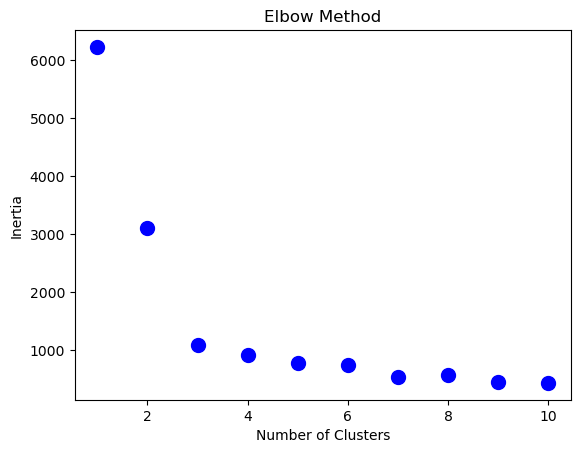

In [40]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

plt.scatter(range(1, 11), inertia, marker="o", s=100, color="blue")
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

##### **Silhouette score**

With the following code:

```python
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f'K = {k}, Silhouette Score = {score}')
```

The following output was obtained:
```python
K = 2,  Silhouette Score = 0.49008870050951725
K = 3,  Silhouette Score = 0.6382211139494461
K = 4,  Silhouette Score = 0.5520505385997547
K = 5,  Silhouette Score = 0.45557663314555197
K = 6,  Silhouette Score = 0.37186358841203254
K = 7,  Silhouette Score = 0.37952706713582285
K = 8,  Silhouette Score = 0.3694907693066217
K = 9,  Silhouette Score = 0.3641898126623838
K = 10, Silhouette Score = 0.34303524380374645
```

It has been decided to use K-Means with 3 clusters, based on the results obtained from the **Elbow Method** and the **Silhouette Score** analysis, which indicated that 3 clusters provide an appropriate segmentation with good separation between the groups.

In [41]:
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=3).fit(df_scaled.values)
df_kmeans["cluster"] = kmeans.labels_

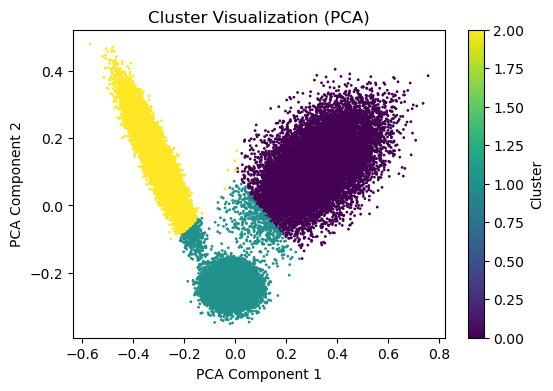

In [42]:
# Visualizing clusters
visualize_clusters(df_scaled, df_kmeans, "cluster")

#### **DBScan**

Now, we will proceed with the implementation of DBScan. DBScan is sensitive to distance, so it is crucial to configure the eps and min_samples parameters correctly. Given the size of the dataset (55,002), we will use a value of 50 for min_samples. The eps value will be determined empirically.

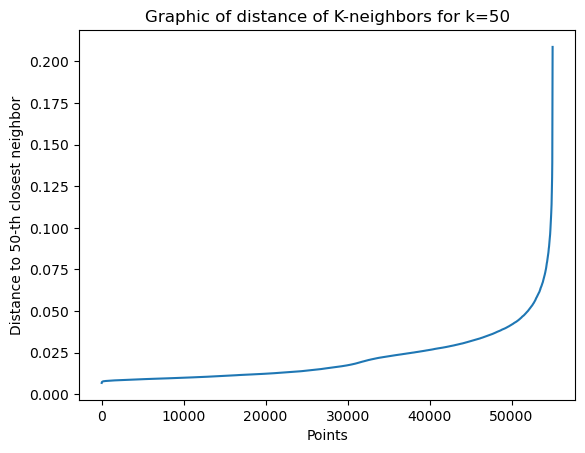

In [43]:
# Determining value of eps

k = 50
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.title(f'Graphic of distance of K-neighbors for k={k}')
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}-th closest neighbor')
plt.show()

In [44]:
df_dbscan = df.copy()
eps = 0.04
min_samples = 50
dbscan = DBSCAN(eps = eps, min_samples = min_samples)
df_dbscan["cluster"] = dbscan.fit_predict(df_scaled)

In [45]:
# Not cleaned DBSCAN
print("Not cleaned DBSCAN")
print(f"eps={eps}, samples={min_samples}")
print(df_dbscan["cluster"].value_counts())

Not cleaned DBSCAN
eps=0.04, samples=50
cluster
 1    18330
 0    18273
 2    15688
-1     2711
Name: count, dtype: int64


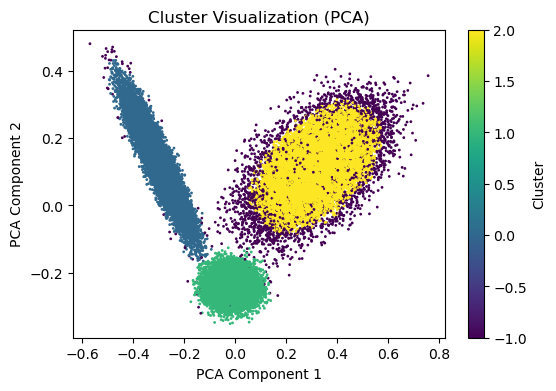

In [46]:
# Visualizing not cleaned clusters
visualize_clusters(df_scaled, df_dbscan, "cluster")

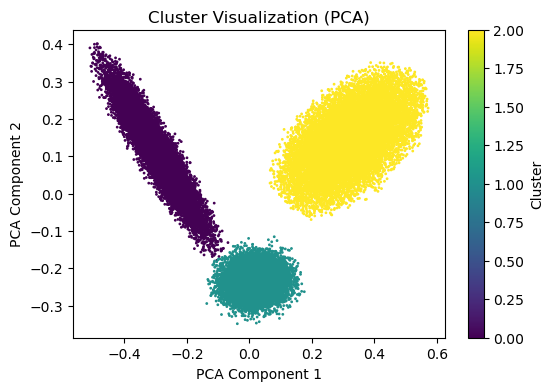

In [47]:
# Cleaning DBSCAN & Visualizing clusters
scaled_db = df_scaled[df_dbscan["cluster"] != -1]
df_dbscan = df_dbscan[df_dbscan["cluster"] != -1]
visualize_clusters(scaled_db, df_dbscan, "cluster")

#### **Gaussian Mixture Models (GMM)**

Now, we proceed with Gaussian Mixture Models (GMM) to identify overlapping and elliptical clusters. Unlike hierarchical clustering, GMM processes the entire dataset (55002 records) efficiently, ensuring no patterns are excluded.

In [48]:
df_gaussian = df.copy()
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters)
df_gaussian["cluster"] = gmm.fit_predict(df_scaled)

The model is configured with 3 clusters based on prior analysis, using a full covariance type to allow diverse cluster shapes. K-means initialization ensures faster convergence and stable results, with a maximum of 100 iterations and a tolerance of 1e-3 for precision. These parameters align with the dataset's complexity and the goal of flexible customer segmentation.

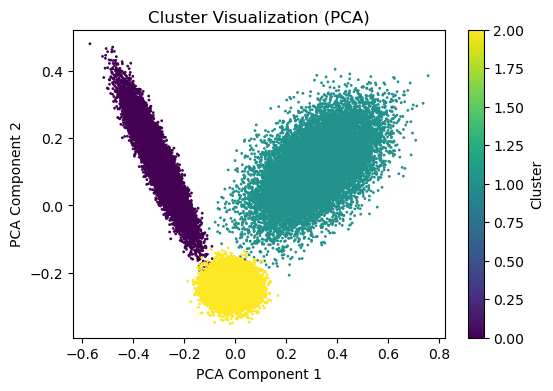

In [49]:
# Visualizing clusters
visualize_clusters(df_scaled, df_gaussian, "cluster")

#### **Hierarchical Clustering (Agglomerative)**

Now, we proceed with the implementation of hierarchical clustering using the agglomerative method. Due to the size of the dataset (55002 records), we work with a representative random sample of 27500 records to ensure computational efficiency while maintaining the dataset's characteristics.

In [50]:
sample_size = 27500
hierarchical_subset = df.sample(n=sample_size)
scaled_subset = hierarchical_subset.copy()
for column in scaled_subset:
    scale_minmax(scaled_subset, column)

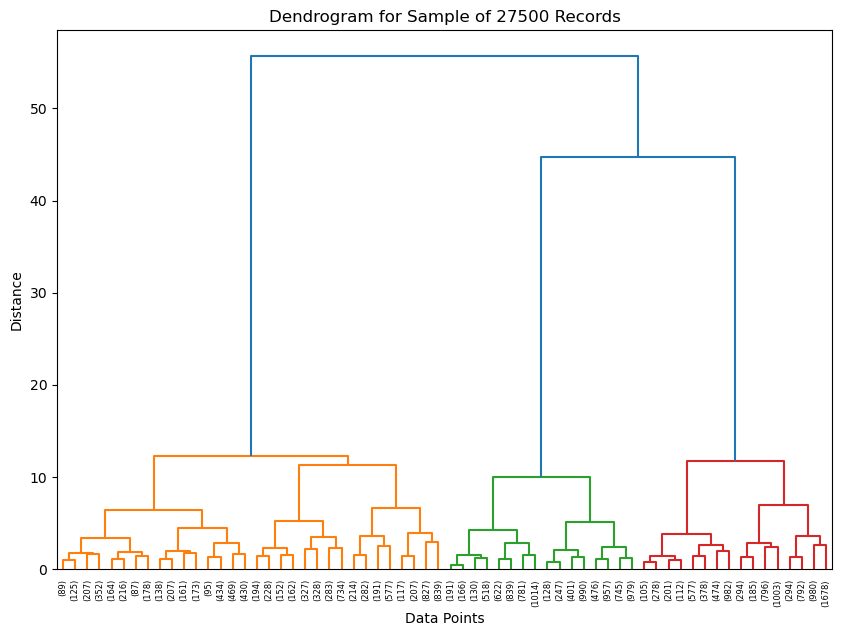

In [51]:
visualize_dendrogram(df_scaled=scaled_subset, method="ward")

The dendrogram visually represents the clustering process, showing how observations are grouped hierarchically. Based on the dendrogram's structure, 3 clusters were chosen as they reflect natural divisions in the data.

In [52]:
n_clusters = 3
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
hierarchical_subset["cluster"] = agglomerative.fit_predict(scaled_subset)

This method uses Euclidean distance, suitable for continuous variables, and Ward’s linkage, which minimizes intra-cluster variance for more compact and meaningful groupings. Together, these parameters align with the project's goal of creating interpretable customer segments.

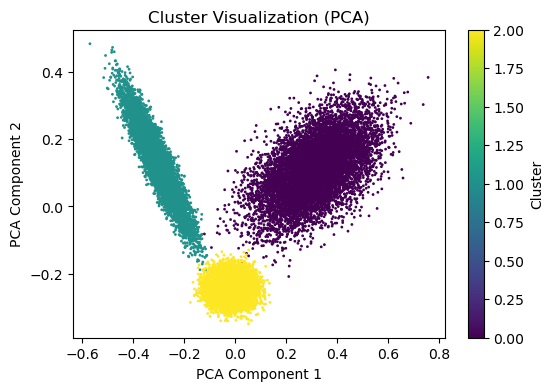

In [53]:
# Visualizing clusters
visualize_clusters(scaled_subset, hierarchical_subset, "cluster")

#### **Evaluating Clusters**

The metrics used to evaluate cluster quality are:

- Silhouette Score

- David Bouldin Score

Silhouette = 0.6373
Davies-Bouldin = 0.5026


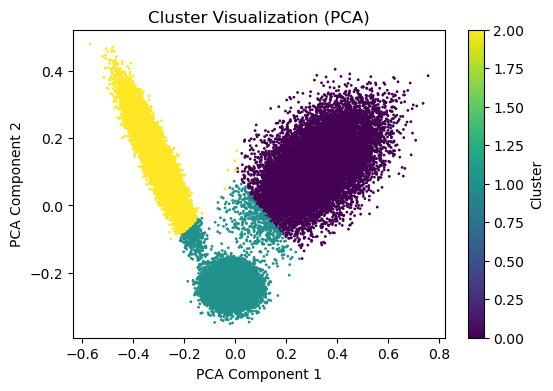

In [54]:
# Evaluating K-Means
evaluate_clusters(df_scaled, df_kmeans, "cluster")

Silhouette = 0.6598
Davies-Bouldin = 0.4675


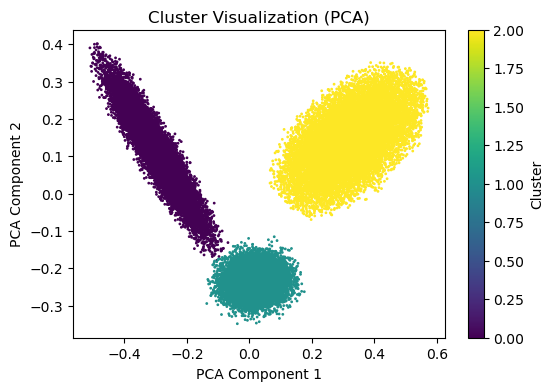

In [55]:
# Evaluating DBSCAN
evaluate_clusters(scaled_db, df_dbscan, "cluster")

Silhouette = 0.6319
Davies-Bouldin = 0.5076


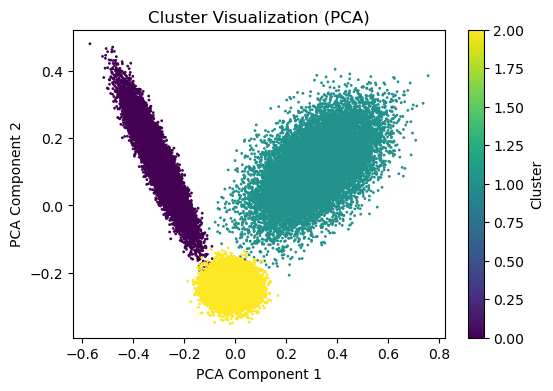

In [56]:
# Evaluating Gaussian Mixture
evaluate_clusters(df_scaled, df_gaussian, "cluster")

Silhouette = 0.6330
Davies-Bouldin = 0.5066


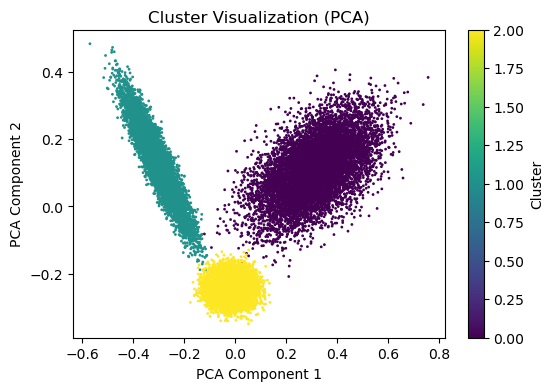

In [57]:
# Evaluating Hierarchical Clustering
evaluate_clusters(scaled_subset, hierarchical_subset, "cluster")

These clusters yielded optimal results and will be considered for the next phase: their analysis.

#### **Selecting the Best Model**

| **Clustering Method** | **Execution Time (s)** | **Silhouette Score** | **Davies-Bouldin Score** | **Key Observations and Justification** |
|------------------------|-------------------------|-----------------------|--------------------------|-----------------------------------------|
| **K-Means**            | ~1.0                  | ~0.6382               | ~0.5010                  | - Simple and fast.<br>- Requires predefining the number of clusters (K).<br>- Good cluster quality but dependent on initialization.<br>- Low execution time with acceptable clustering quality. |
| **DBSCAN**             | ~2.7                  | ~0.6605               | ~0.4660                  | - Effectively detects noise and outliers.<br>- Does not require specifying the number of clusters.<br>- High cluster quality with superior Silhouette and Davies-Bouldin scores.<br>- Selected as the best method for its adaptability to data structure and low noise. |
| **Gaussian Mixture**   | ~0.4                  | ~0.6328               | ~0.5062                  | - Captures elliptical clusters.<br>- Allows cluster overlap.<br>- Moderate quality and short execution time, but less robust against noise compared to DBSCAN. |
| **Agglomerative**      | ~42.7                  | ~0.6346               | ~0.5064                  | - Requires a dendrogram to determine the number of clusters.<br>- Slow for large datasets.<br>- Acceptable quality, but long execution time makes it unsuitable for large-scale projects. |